In [312]:
import tensorflow as tf
import nltk
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import train_test_split
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  
def put_label(stars):
  if stars<=2:
    return 0
  elif stars==3:
    return 1
  else:
    return 2
  
def leer_datos(path):
    data = []
    with open(path, 'r', encoding='utf-8') as archivo: 
        reader = csv.reader(archivo)
        header = next(reader, None)  # Obtener la primera línea como encabezado
        for linea in reader:
            data.append(linea)

    return header, data

In [313]:
header,raw_dataset=leer_datos("/mnt/d/Descargas/Reviews/Reviews.csv")

In [314]:
print("hay",len(raw_dataset),"datos. Cada uno con",len(header),"caracteristicas")
print("columnas:")
print(header,"\n")
print(raw_dataset[1], "\n")
print(raw_dataset[2])

hay 568454 datos. Cada uno con 10 caracteristicas
columnas:
['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'] 

['2', 'B00813GRG4', 'A1D87F6ZCVE5NK', 'dll pa', '0', '0', '1', '1346976000', 'Not as Advertised', 'Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".'] 

['3', 'B000LQOCH0', 'ABXLMWJIXXAIN', 'Natalia Corres "Natalia Corres"', '1', '1', '4', '1219017600', '"Delight" says it all', 'This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis\' "The Lion,

In [315]:
columnas = [6,8,9]
reviews = [[row[i] for i in columnas] for row in raw_dataset]
print(reviews[2])

['4', '"Delight" says it all', 'This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis\' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.']


In [316]:
label_counter = [0,0,0]
for i in range(len(reviews)):
    if reviews[i][0] == '1' or reviews[i][0] == '2':
        reviews[i][0] = 0
        label_counter[0] += 1
    elif reviews[i][0] == '3':
        reviews[i][0] = 1
        label_counter[1] += 1
    else:
        reviews[i][0] = 2
        label_counter[2] += 1
print(label_counter)

[82037, 42640, 443777]


In [317]:
import random
def randomize(lista):
    randomized = lista[:]  
    random.shuffle(randomized)
    return randomized
reviews = randomize(reviews)
print(reviews[0])

[0, "If you're expecting a VIA-like coffee, forget it.", "This product is obviously aimed at those who are enjoying Starbuck's VIA coffee (which isn't bad). This, however, looks and tastes pretty much like any instant coffee. It's not microground like VIA. Just get a regular jar of this stuff if you like it."]


In [318]:
reviews_compressed = []
label_check = [0,0,0]
for i in range(len(reviews)):
    if label_check[0] == label_check[1] == label_check[2] == 42640:
        break
    if reviews[i][0] == 0 and label_check[0] < 42640:
        reviews_compressed.append(reviews[i])
        label_check[0] += 1
    elif reviews[i][0] == 1 and label_check[1] < 42640:
        reviews_compressed.append(reviews[i])
        label_check[1] += 1
    elif reviews[i][0] == 2 and label_check[2] < 42640:
        reviews_compressed.append(reviews[i])
        label_check[2] += 1
print(label_check)
print(len(reviews_compressed))
reviews = reviews_compressed

[42640, 42640, 42640]
127920


In [319]:
X=[text[1] for text in reviews]
y=[label[0] for label in reviews]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [320]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
for i in range(5):
    print(X_train[i])



Saved my Cat
don't stop chewing!
Booda Bone Dog Treats, 9 Pack
Amazing Service
we will see


In [321]:


vocab_size=1000
encoder=tf.keras.layers.TextVectorization(max_tokens=vocab_size)

encoder.adapt(X_train)

vocab = np.array(encoder.get_vocabulary())
vocab[:20]





array(['', '[UNK]', 'not', 'the', 'good', 'but', 'great', 'a', 'for',
       'and', 'it', 'my', 'i', 'to', 'taste', 'is', 'this', 'of',
       'coffee', 'too'], dtype='<U14')

In [322]:
model=tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=80,
        mask_zero=True
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(80)),
    tf.keras.layers.Dense(80,activation='relu'),
    tf.keras.layers.Dense(3,activation='softmax')#Solo hay 3 clases
])

In [323]:
print([layer.supports_masking for layer in model.layers])


[False, True, True, True, True]


In [324]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])


1/1 [==============================] - 1s 1s/step
[0.33544964 0.33310992 0.3314405 ]


In [325]:
padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])


1/1 [==============================] - 0s 82ms/step
[0.3354499  0.33310992 0.33144018]


In [326]:
model.compile(loss= 'categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])


In [327]:

for i in range (5):
    print(X_train[i]+' '+str(y_train[i]))

Saved my Cat 2
don't stop chewing! 1
Booda Bone Dog Treats, 9 Pack 2
Amazing Service 2
we will see 1


In [328]:
num_classes = 3  # Número de clases
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test=tf.keras.utils.to_categorical(y_test, num_classes)
print(y_train)

[[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [329]:
X_train=tf.constant(X_train, dtype=tf.string)
X_test=tf.constant(X_test,dtype=tf.string)

In [330]:
print(X_train[1])
print(y_train[1])

tf.Tensor(b"don't stop chewing!", shape=(), dtype=string)
[0. 1. 0.]


In [331]:
print(y_train[4])
print(X_train[4])
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

[0. 1. 0.]
tf.Tensor(b'we will see', shape=(), dtype=string)
102336
102336
25584
25584


In [332]:
history = model.fit(X_train,y_train, epochs=18,
                    validation_data=(X_test,y_test),
                    validation_steps=30)


Epoch 1/18


3198/3198 [==============================] - 62s 18ms/step - loss: 0.8042 - accuracy: 0.6243 - val_loss: 0.7231 - val_accuracy: 0.6686
Epoch 2/18
3198/3198 [==============================] - 54s 17ms/step - loss: 0.7090 - accuracy: 0.6739 - val_loss: 0.7096 - val_accuracy: 0.6751
Epoch 3/18
3198/3198 [==============================] - 53s 16ms/step - loss: 0.6981 - accuracy: 0.6808 - val_loss: 0.7048 - val_accuracy: 0.6794
Epoch 4/18
3198/3198 [==============================] - 53s 17ms/step - loss: 0.6895 - accuracy: 0.6856 - val_loss: 0.6977 - val_accuracy: 0.6825
Epoch 5/18
3198/3198 [==============================] - 53s 17ms/step - loss: 0.6809 - accuracy: 0.6917 - val_loss: 0.6939 - val_accuracy: 0.6842
Epoch 6/18
3198/3198 [==============================] - 53s 17ms/step - loss: 0.6731 - accuracy: 0.6950 - val_loss: 0.6893 - val_accuracy: 0.6871
Epoch 7/18
3198/3198 [==============================] - 53s 17ms/step - loss: 0.6654 - accuracy: 0.6982 - val_loss: 0.6864 - val_accura

In [335]:

test_loss, test_acc = model.evaluate(X_test,y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

800/800 [==============================] - 6s 8ms/step - loss: 0.6790 - accuracy: 0.6993
Test Loss: 0.6790053248405457
Test Accuracy: 0.69926518201828


(0.0, 0.8141134530305862)

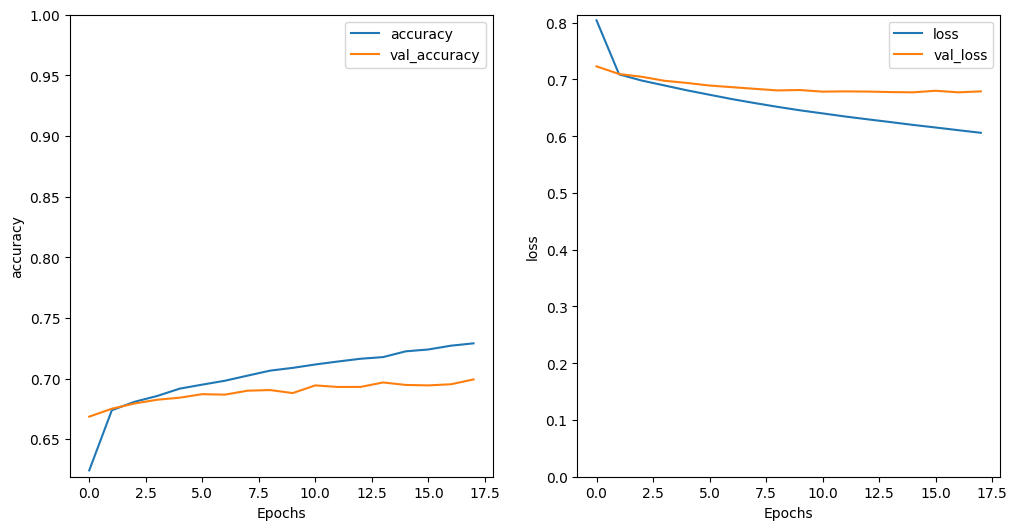

In [338]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)


In [339]:
sample_text = ('The movie was quite slow, i would reccomend it but i dont know who may like it')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 1s 1s/step
[0.11331494 0.8742776  0.01240741]


In [340]:
tf.saved_model.save(model, '/mnt/d/Repositorios/Deep_Learning/Temas Selectos/P1/lstm_model')


INFO:tensorflow:Assets written to: /mnt/d/Repositorios/Deep_Learning/Temas Selectos/P1/lstm_model/assets


INFO:tensorflow:Assets written to: /mnt/d/Repositorios/Deep_Learning/Temas Selectos/P1/lstm_model/assets
